## COVID Pipeline Deployment on UCS

### Clone Cisco Kubeflow Starter Pack Repository

In [3]:
! git clone https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

Cloning into 'cisco-kubeflow-starter-pack'...
remote: Enumerating objects: 1681, done.
remote: Total 1681 (delta 0), reused 0 (delta 0), pack-reused 1681
Receiving objects: 100% (1681/1681), 4.45 MiB | 6.38 MiB/s, done.
Resolving deltas: 100% (661/661), done.


### Import libraries

In [20]:
import kfp
import os
import calendar
import time
from kubernetes import client
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly_express as px
%matplotlib inline


### Component files Declarations

In [2]:
path='cisco-kubeflow-starter-pack/apps/healthcare/covid-forecasting/onprem/pipelines/'
component_root_preprocess = path + 'components/covid_preprocess/'
component_root_train = path + 'components/covid_train/'
component_root_serve = path + 'components/covid_serve/'

#### Components Description
covid_datadownload_op &nbsp; - &nbsp; Downloads dataset from GCP bucket and stores in nfs-volume. <br>
covid_preprocess_op &nbsp; - &nbsp; Preprocess the raw dataset to make it suitable for training. <br>
covid_train_op &nbsp; - &nbsp; Load dataset from nfs-volume, train COVID-19 model and saves model in nfs-volume. <br>
covid_serve_op &nbsp; - &nbsp; Load COVID-19 model from nfs-volume and serve the model using tf-serving for later prediction. <br> 
covid_upload_result_op &nbsp; - &nbsp; Uploading the prediction results into GCS bucket for the sake of visualisation. <br> 



### Load components from respective .YAML config files

In [3]:
covid_preprocess_op = kfp.components.load_component_from_file(os.path.join(component_root_preprocess, 'component.yaml'))
covid_train_op = kfp.components.load_component_from_file(os.path.join(component_root_train, 'component.yaml'))
covid_serve_op = kfp.components.load_component_from_file(os.path.join(component_root_serve, 'component.yaml'))

### Define Volume and Volume Mounts

In [4]:
nfs_pvc = client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs')
nfs_volume = client.V1Volume(name='nfs', persistent_volume_claim=nfs_pvc)
nfs_volume_mount = client.V1VolumeMount(mount_path='/mnt/', name='nfs')

### Create Timestamp

In [5]:
timestamp = str(calendar.timegm(time.gmtime()))
print(timestamp)

1588266625



### Define pipeline function

In [6]:
def covid_pipeline():
    
    #Define Task for Preprocess covid data
    covid_preprocess_task = covid_preprocess_op()
    covid_preprocess_task.add_volume(nfs_volume)
    covid_preprocess_task.add_volume_mount(nfs_volume_mount)
    
    #Define Task for Training model for COVID-19 prediction
    covid_train_task = covid_train_op(epochs=10)
    covid_train_task.add_volume(nfs_volume)
    covid_train_task.add_volume_mount(nfs_volume_mount)
    covid_train_task.after(covid_preprocess_task)
    
    #Define Task for Serving for COVID-19 prediction
    covid_serve_task = covid_serve_op(timestamp=timestamp)
    covid_serve_task.add_volume(nfs_volume)
    covid_serve_task.add_volume_mount(nfs_volume_mount)
    covid_serve_task.after(covid_train_task)    

### Create & Execute a COVID Forcast Pipeline

In [7]:
#Create a pipeline run
kfp.Client().create_run_from_pipeline_func(covid_pipeline, arguments={})

RunPipelineResult(run_id=7dbeddd9-24bb-441c-8929-1760034be1c9)

## Preprocessing test dataset

In [13]:
def preprocess_test(n_prev):
    input_feats = []
    
    #Appending the training data with test data records with date of specified no of forecasting dates
    append_df = pd.concat([train_df, test_df[test_df["Date"] == train_df["Date"].max() + timedelta(days=1)]])
    
    #Sorting the Dataframe in ascending order of Country region, province state & Date
    append_df.sort_values(["Country_Region", "Province_State", "Date"], ascending=[True, True, True], inplace=True)
    
    # Performing Shifting of Previous cases in the positive direction (downwards) for New cases & New Fatalities
    for i in range(1, n_prev+1):
        for feat in ["NewCases", "NewFatalities"]:
            append_df["{}_prev_{}".format(feat, i)] = append_df.groupby(["Country_Region", "Province_State"])[feat].shift(i)
            input_feats.append("{}_prev_{}".format(feat, i))
            
    # Adding a column of ForecastId if records are not having null values        
    append_df = append_df[append_df["ForecastId"].notnull()]
    
    #Converting the Province state & Country Region to Dummy/Indicator Variables ( which is a constant)
    const_df = pd.get_dummies(append_df[["Province_State", "Country_Region"]], drop_first=True)
    
    # Assigning already available data for previous no of days counting back from starting date of forecasting dates
    time_df = append_df[input_feats]
    time_df = time_df.values.reshape((append_df.shape[0],-1,2))
    
    return const_df, time_df

In [28]:
# Read train and test datasets
train_df = pd.read_csv("./../data/train.csv")
print("train_df shape: {0}" .format(train_df.shape))
test_df = pd.read_csv("./../data/test.csv")
print("train_df shape: {0}" .format(test_df.shape))

# Check the NaN value status in each column of the Train data
# Checking whether no column except Province_State are having NaN values
train_df.apply(lambda col: col.isnull().value_counts(), axis=0)
test_df.apply(lambda col: col.isna().value_counts(), axis=0)

# Replace the values of NaN with ""
train_df["Province_State"] = train_df["Province_State"].fillna("")
test_df["Province_State"] = test_df["Province_State"].fillna("")

# Convert the Date column values to Pandas Datetime format
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

# Add New Columns for "NewCases" and Fill the Column with difference values from the previous rows
train_df["NewCases"] = train_df.groupby(["Country_Region", "Province_State"])["ConfirmedCases"].diff(periods=1)

# Replace "NewCases" NaN values with 0
train_df["NewCases"] = train_df["NewCases"].fillna(0)

# Ensure that the NewCases are not negative. If NewCases are negative then they are replaced with zero else the actual value is provided
train_df["NewCases"] = np.where(train_df["NewCases"] < 0, 0, train_df["NewCases"])

# Add a column for "NewFatalities" same as for "NewCases"
train_df["NewFatalities"] = train_df.groupby(["Country_Region", "Province_State"])["Fatalities"].diff(periods=1)
train_df["NewFatalities"] = train_df["NewFatalities"].fillna(0)
train_df["NewFatalities"] = np.where(train_df["NewFatalities"] < 0, 0, train_df["NewFatalities"])

# Apply Natural Logarithmic Function to NewCases and NewFatalities Column
train_df["NewCases"] = np.log(train_df["NewCases"] + 1)
train_df["NewFatalities"] = np.log(train_df["NewFatalities"] + 1)

train_df shape: (28170, 6)
train_df shape: (13459, 4)


In [29]:
n_next = (test_df["Date"].max() - train_df["Date"].max()).days
print("No of Future Days requested to forecast COVID-19 New Cases & New Fatalities:", n_next)
const_test_df, time_test_df = preprocess_test(n_next)

No of Future Days requested to forecast COVID-19 New Cases & New Fatalities: 24


## Predict data from tf-serving using tfserving service IP

In [30]:
import requests
import json
headers = {"HOST":"covid-model.anonymous.example.com"}
instances=[]
for i in range(len(time_test_df)):
    instances.append({"input1":time_test_df[i].tolist(), "input2":const_test_df.values[i].tolist()})
data={"signature_name":"serving_default","instances":instances}
response=requests.post("http://10.108.248.147:8500/v1/models/Model_Covid:predict", headers=headers, data=json.dumps(data))
predictions=response.json()['predictions']
print(len(predictions))
predictions[0]

313


[0.0636984482,
 0.000205952325,
 0.0101763327,
 0.000238964247,
 0.0166200735,
 0.000268304459,
 0.00184714061,
 0.000238659515,
 0.00212091813,
 0.000270966266,
 0.00162749086,
 0.000249645,
 0.00139446976,
 0.000119092547,
 0.00266409665,
 0.000168830957,
 0.00229671318,
 0.000229755533,
 0.0036853794,
 0.000550413737,
 0.00296545727,
 0.000156250811,
 0.00218599476,
 0.000190544335,
 0.00363669987,
 0.000134557951,
 0.00320992107,
 0.000242600785,
 0.00378876901,
 0.000330157549,
 0.00417128578,
 0.000207273086,
 0.00943038054,
 0.000213303691,
 0.031801112,
 0.000246626325,
 0.106799699,
 0.000268389442,
 0.109469272,
 0.000156017486,
 0.199328884,
 0.000138671952,
 0.144784808,
 0.000152511813,
 0.164809138,
 0.000285380578,
 0.102045193,
 0.000179435854]

#### Filter the part of test data with specified future dates and covert the exponential format back to normal values

Also concatenating the Predicted New Cases & New Fatalities to the data

In [31]:
sub_test_df = test_df[test_df["Date"] > train_df["Date"].max()]
sub_test_df = pd.concat([sub_test_df,
                         pd.DataFrame(np.array(predictions).reshape((-1, 2)), columns=["NewCases", "NewFatalities"], index=sub_test_df.index)],
                         axis=1)
sub_test_df["NewCases"] = np.exp(sub_test_df["NewCases"]) - 1
sub_test_df["NewFatalities"] = np.exp(sub_test_df["NewFatalities"]) - 1
# sub_test_df.head()

# Filtering the part of test data with available dates and merging leftout dates if any
fixed_test_df = test_df[test_df["Date"] <= train_df["Date"].max()].merge(train_df[train_df["Date"] >= test_df["Date"].min()][["Province_State","Country_Region", "Date", "ConfirmedCases", "Fatalities"]],
                                                                         how="left", on=["Province_State","Country_Region", "Date"])
fixed_test_df

# Concatenate the fixed_test data with the sub_test data ( which includes predicted New cases & New Fatalities)
predict_df = pd.concat([sub_test_df, fixed_test_df]).sort_values(["Country_Region", "Province_State", "Date"],
                                                                 ascending=[True, True, True])

# Add a new Index column to Predict_df
predict_df = predict_df.reset_index()

# Replace null values of Confirmed Cases & Fatalities using New Cases & New Fatalities by accumulation
for i in range(len(predict_df)):
    if pd.isnull(predict_df.iloc[i]["ConfirmedCases"]):
        predict_df.loc[i, "ConfirmedCases"] = predict_df.iloc[i - 1]["ConfirmedCases"] + predict_df.iloc[i]["NewCases"]
    if pd.isnull(predict_df.iloc[i]["Fatalities"]):
        predict_df.loc[i, "Fatalities"] = predict_df.iloc[i - 1]["Fatalities"] + predict_df.iloc[i]["NewFatalities"]

# Ensure shape of Prediction result is same with test data
assert predict_df.shape[0] == test_df.shape[0]

# Get the Prediction result of Confirmed Cases & Fatalities for the specified future dates
predict_df[["ForecastId", "ConfirmedCases", "Fatalities"]].to_csv("submission.csv", index=False)
predict_df[["ForecastId", "ConfirmedCases", "Fatalities"]].head()

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0


### Filter India's Data & Visualise

#### Visualise matplotlib plot for analysing the trend of predicted Confirmed Cases in India against the dates extending till the specified future dates

In [32]:
country = "India"

target = "ConfirmedCases"
region_train_df = train_df[(train_df["Country_Region"]==country)]
region_predict_df = predict_df[(predict_df["Country_Region"]==country)]

fig = plt.figure(figsize=(10, 6))

fig = px.line(region_train_df, x="Date", y=target, title='Prediction in India')
fig = px.line(region_predict_df, x="Date", y=target, title='Prediction in India')
fig.show()

<Figure size 720x432 with 0 Axes>

#### Visualise Plotly plot showing the overall trend of increasing Confirmed Cases right from the beginning of spread till the future date

The intersection of the green and the red line shows the breaking point whether the cases starts to increase drastically

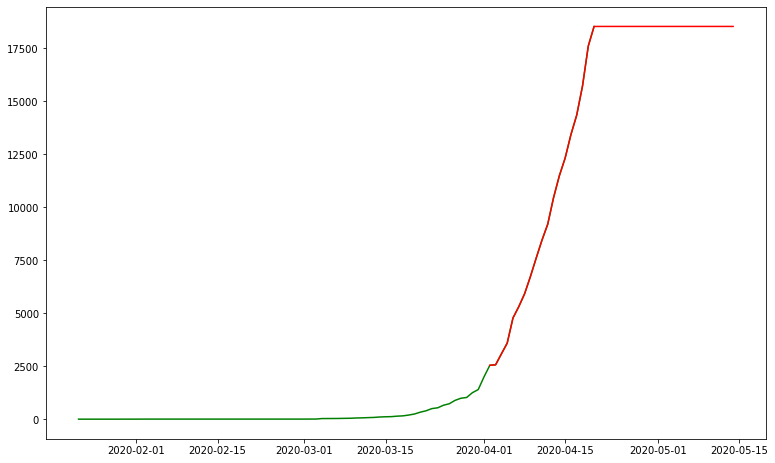

In [33]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_axes([0, 0, 1, 1])
ax1.plot(region_train_df["Date"],
         region_train_df[target],
         color="green")

ax1.plot(region_predict_df["Date"],
         region_predict_df[target],
         color="red")
plt.show()